In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly.
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../../..'))
	print(os.getcwd())
except:
	pass

/home/afonso/Projects/Python/MScThesis


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.callbacks import Callback
import matplotlib
from keras.optimizers import RMSprop
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import category_encoders as ce

from src import consts as const
from src import utils

Using TensorFlow backend.
/home/afonso/anaconda3/envs/thesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/afonso/anaconda3/envs/thesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/afonso/anaconda3/envs/thesis/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/afonso/anacond

/home/afonso/Projects/Python/MScThesis/data/processed


In [3]:
df_incomplete, df_no_nan, df = utils.imputation_dataset(
    const.PROCESSED_DATA_DIR / 'impute_dataset.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_incomplete, df_no_nan, test_size=0.3)

In [5]:
encoder = ce.TargetEncoder(verbose=2, handle_missing='return_nan')
cat_cols = X_train.select_dtypes(include=['object']).columns

X_train_encoded = encoder.fit_transform(X_train[cat_cols], y_train['air_time'])
X_train[cat_cols] = X_train_encoded
y_train_encoded = encoder.fit_transform(y_train[cat_cols], y_train['air_time'])
y_train[cat_cols] = y_train_encoded

X_test_encoded = encoder.fit_transform(X_test[cat_cols], y_test['air_time'])
X_test[cat_cols] = X_test_encoded
y_test_encoded = encoder.fit_transform(y_test[cat_cols], y_test['air_time'])
y_test[cat_cols] = y_test_encoded

/home/afonso/anaconda3/envs/thesis/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [6]:
import random

import numpy as np
import tensorflow as tf

Normal = tf.contrib.distributions.Normal
np.random.seed(0)
tf.set_random_seed(0)


def xavier_init(fan_in, fan_out, constant=1):
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)


class TFVariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.

    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.

    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """

    def __init__(self, network_architecture, transfer_fct=tf.nn.relu,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        # tf Graph input
        self.x = tf.placeholder(
            tf.float32, [None, network_architecture["n_input"]])

        # Create autoencoder network
        self._create_network()

        # Define loss function based variational upper-bound and
        # corresponding optimizer
        self._create_loss_optimizer()

        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)

    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"],
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        eps = tf.random_normal(tf.shape(self.z_mean), 0, 1,
                               dtype=tf.float32)
        # writing eps as above keeps self.z of the same size as the input, so
        # it is not tied to a specific batch size as in the original (below)
#        eps = tf.random_normal((self.batch_size, n_z), 0, 1,
#                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean and
        # (log) variance of Gaussian distribution of reconstructed input
        self.x_hat_mean, self.x_hat_log_sigma_sq = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])

    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2,
                            n_hidden_gener_1,  n_hidden_gener_2,
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights

    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a normal distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']),
                                           biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']),
                                           biases['b2']))
        x_hat_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                            biases['out_mean'])
        x_hat_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (x_hat_mean, x_hat_log_sigma_sq)

    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Gaussian distribution
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.

        X_hat_distribution = Normal(loc=self.x_hat_mean,
                                    scale=tf.exp(self.x_hat_log_sigma_sq))
        reconstr_loss = \
            -tf.reduce_sum(X_hat_distribution.log_prob(self.x), 1)

        # 2.) The latent loss, which is defined as the Kullback Leibler divergence
        # between the distribution in latent space induced by the encoder on
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq
                                           - tf.square(self.z_mean)
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(
            reconstr_loss + latent_loss)   # average over batch

#        # Use ADAM optimizer
#        self.optimizer = \
#            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

        # Use RMSProp optimizer
        self.optimizer = \
            tf.train.RMSPropOptimizer(
                learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None, n_samples=100):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(
                size=[n_samples, self.network_architecture["n_z"]])

        x_hat_mu, x_hat_logsigsq = self.sess.run((self.x_hat_mean, self.x_hat_log_sigma_sq),
                                                 feed_dict={self.z: z_mu})

        eps = tf.random_normal(tf.shape(x_hat_mu), 0, 1,
                               dtype=tf.float32)

        # x_hat_gen = mu + sigma*epsilon
        x_hat_gen = tf.add(x_hat_mu,
                           tf.multiply(tf.sqrt(tf.exp(x_hat_logsigsq)), eps))

        return x_hat_gen

    def reconstruct(self, X, sample='mean'):
        """ Use VAE to reconstruct given data, using the mean of the 
            Gaussian distribution of the reconstructed variables by default, 
            as this gives better imputation results.
            Data can also be reconstructed by sampling from the Gaussian
            distribution of the reconstructed variables, by specifying the
            input variable "sample" to value 'sample'.
        """
        if sample == 'sample':
            x_hat_mu, x_hat_logsigsq = self.sess.run((self.x_hat_mean, self.x_hat_log_sigma_sq),
                                                     feed_dict={self.x: X})

            eps = tf.random_normal(tf.shape(X), 0, 1,
                                   dtype=tf.float32)
            # x_hat = mu + sigma*epsilon
            x_hat = tf.add(x_hat_mu,
                           tf.multiply(tf.sqrt(tf.exp(x_hat_logsigsq)), eps))
            # evaluate the tensor, as indexing into tensors seems to be a
            # a missing function in tf:
            x_hat = x_hat.eval()
        else:
            x_hat_mu = self.sess.run(self.x_hat_mean,
                                     feed_dict={self.x: X})
            x_hat = x_hat_mu

        return x_hat

    def impute(self, X_corrupt, max_iter=10):
        """ Use VAE to impute missing values in X_corrupt. Missing values
            are indicated by a NaN.
        """
        # Select the rows of the datset which have one or more missing values:
        NanRowIndex = np.where(np.isnan(np.sum(X_corrupt, axis=1)))
        x_miss_val = X_corrupt[NanRowIndex[0], :]

        # initialise missing values with arbitrary value
        NanIndex = np.where(np.isnan(x_miss_val))
        x_miss_val[NanIndex] = 0

        MissVal = np.zeros([max_iter, len(NanIndex[0])], dtype=np.float32)

        for i in range(max_iter):
            MissVal[i, :] = x_miss_val[NanIndex]

            # reconstruct the inputs, using the mean:
            x_reconstruct = self.reconstruct(x_miss_val)
            x_miss_val[NanIndex] = x_reconstruct[NanIndex]

        X_corrupt[NanRowIndex, :] = x_miss_val
        X_imputed = X_corrupt
        self.MissVal = MissVal

        return X_imputed

    def train(self, XData, training_epochs=10, display_step=10):
        """ Train VAE in a loop, using numerical data"""

        def next_batch(Xdata, batch_size, MissingVals=True):
            """ Randomly sample batch_size elements from the matrix of data, Xdata.
                Xdata is an [NxM] matrix, N observations of M variables.
                batch_size must be smaller than N.

                Returns Xdata_sample, a [batch_size x M] matrix.
            """
            if MissingVals:
                # This returns records with any missing values replaced by 0:
                X_indices = random.sample(range(Xdata.shape[0]), batch_size)
                Xdata_sample = np.copy(Xdata[X_indices, :])
                NanIndex = np.where(np.isnan(Xdata_sample))
                Xdata_sample[NanIndex] = 0
            else:
                # This returns complete records only:
                ObsRowIndex = np.where(np.isfinite(np.sum(Xdata, axis=1)))
                X_indices = random.sample(list(ObsRowIndex[0]), batch_size)
                Xdata_sample = np.copy(Xdata[X_indices, :])

            return Xdata_sample

        # number of rows with complete entries in XData
        NanRowIndex = np.where(np.isnan(np.sum(XData, axis=1)))
        n_samples = np.size(XData, 0) - NanRowIndex[0].shape[0]

        losshistory = []
        losshistory_epoch = []
        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(n_samples / self.batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_xs = next_batch(
                    XData, self.batch_size, MissingVals=True)
                # Fit training using batch data
                cost = self.partial_fit(batch_xs)
                # Compute average loss
                avg_cost += cost / n_samples * self.batch_size
            # Display logs per epoch step
            if epoch % display_step == 0:
                losshistory_epoch.append(epoch)
                losshistory.append(-avg_cost)
                print(f'Epoch: {epoch+1:.4f} Cost= {avg_cost:.9f}')
        self.losshistory = losshistory
        self.losshistory_epoch = losshistory_epoch
        return self


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [7]:
y_train_arr = y_train.values.astype(float)

In [8]:
X_train_arr = X_train.values.astype(float)

In [26]:
# Properties of data:
n_x = X_train_arr.shape[1]
NanIndex = np.where(np.isnan(X_train_arr))
obs_row_idx = np.where(np.isfinite(np.sum(X_train_arr,axis=1)))

# Number of missing values
NanCount = len(NanIndex[0])

# Zscore for reconstruction error checking:
scRecon = StandardScaler()
scRecon.fit(y_train_arr)

# Zscore of data produces much better results
sc = StandardScaler()
X_train_complete_records = X_train_arr[obs_row_idx]
# standardise using complete records:
sc.fit(X_train_complete_records)
#X_train_arr[NanIndex] = 0

X_train_arr = sc.transform(X_train_arr)
y_train_arr = sc.transform(y_train_arr)
#X_train_arr[NanIndex] = np.nan
del X_train_complete_records

In [27]:
y_train_arr

array([[ 0.04042844, -0.2175092 , -0.13079725, ..., -0.31139077,
        -0.45829065,  1.02927244],
       [ 0.22672808,  0.04644868,  1.12934412, ..., -0.53467645,
         0.47465492,  1.02927244],
       [-0.77190705,  0.04644868, -1.12437025, ..., -1.3161763 ,
        -1.39123623,  1.32007546],
       ...,
       [ 0.04042844, -0.87882601,  1.03241016, ...,  1.36325178,
        -0.08511242,  0.73846943],
       [-0.78371116,  0.04644868,  0.93547621, ..., -0.0881051 ,
        -1.57782535,  0.15686341],
       [ 0.04042844, -0.72445768,  1.03241016, ..., -1.53946198,
         1.22101139, -1.58795467]])

In [28]:
X_train_arr

array([[ 0.03959337,         nan, -0.13079725, ..., -0.31139077,
        -0.45829065,  1.02927244],
       [ 0.22847605,  0.04950452,  1.12934412, ..., -0.53467645,
         0.47465492,  1.02927244],
       [-0.77464551,  0.04950452, -1.12437025, ..., -1.3161763 ,
        -1.39123623,  1.32007546],
       ...,
       [ 0.03959337, -0.88126021,  1.03241016, ...,  1.36325178,
        -0.08511242,  0.73846943],
       [        nan,         nan,         nan, ..., -0.0881051 ,
        -1.57782535,  0.15686341],
       [ 0.03959337, -0.72380571,  1.03241016, ..., -1.53946198,
         1.22101139, -1.58795467]])

In [29]:
X_train_arr[NanIndex]

array([nan, nan, nan, ..., nan, nan, nan])

In [ ]:
# VAE network size:
Decoder_hidden1 = 32
Decoder_hidden2 = 64
Encoder_hidden1 = 64
Encoder_hidden2 = 32

# dimensionality of latent space:
latent_size = 16

# training parameters:
training_epochs = 400
batch_size = 256
learning_rate = 0.001

# INITIALISE AND TRAIN VAE
# define dict for network structure:
network_architecture = \
    dict(n_hidden_recog_1=Encoder_hidden1, # 1st layer encoder neurons
         n_hidden_recog_2=Encoder_hidden2, # 2nd layer encoder neurons
         n_hidden_gener_1=Decoder_hidden1, # 1st layer decoder neurons
         n_hidden_gener_2=Decoder_hidden2, # 2nd layer decoder neurons
         n_input=n_x, # data input size
         n_z=latent_size)  # dimensionality of latent space

# initialise VAE:
vae = TFVariationalAutoencoder(network_architecture, 
                             learning_rate=learning_rate, 
                             batch_size=batch_size)

# train VAE on corrupted data:
vae = vae.train(XData=y_train_arr,
                training_epochs=training_epochs)

# plot training history:
fig = plt.figure(dpi = 150)
plt.plot(vae.losshistory_epoch,vae.losshistory)
plt.xlabel('Epoch')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.show()

In [14]:
# IMPUTE MISSING VALUES
# impute missing values:
X_impute = vae.impute(X_corrupt = X_train_arr)

In [15]:
NanCount

796839

In [16]:
NanIndex[0]

array([     0,      0,      0, ..., 159591, 159591, 159591])

In [17]:
NanIndex[1]

array([ 4, 11, 26, ..., 34, 43, 44])

In [23]:
actual_values = Xdata[NanIndex[0]][NanIndex[1]]

In [24]:
actual_values

array([[ 0.03918581,  0.71854868,  1.03417679, ..., -1.42974795,
        -2.1335551 , -1.58545855],
       [ 0.03918581,  0.71854868,  1.03417679, ..., -1.42974795,
        -2.1335551 , -1.58545855],
       [-0.12516939,  0.04915428,  0.86446508, ..., -1.20628153,
        -1.01460432, -1.58545855],
       ...,
       [ 1.94307041,  0.04915428, -1.12358637, ...,  0.91664953,
        -0.26863713, -0.42242075],
       [-0.10928662, -0.73105647, -1.12358637, ..., -0.9828151 ,
         1.78277263,  1.61289539],
       [-0.10928662, -0.73105647, -1.12358637, ..., -0.9828151 ,
         1.78277263,  1.61289539]])

In [28]:
Xdata_Missing[NanIndex]

array([-0.06898227,  0.01186251, -1.26237059, ...,  0.05439732,
       -0.01271103, -0.01419282])

In [29]:
X_impute[NanIndex]

array([-0.06898227,  0.01186251, -1.26237059, ...,  0.05439732,
       -0.01271103, -0.01419282])

In [ ]:
# plot imputation results for one variable:
var_i = 0
min_i = np.min(Xdata[:,var_i])
max_i = np.max(Xdata[:,var_i])

fig = plt.figure(dpi = 150)
plt.plot(Xdata[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],X_impute[NanIndex[0][np.where(NanIndex[1]==var_i)],var_i],'.')
plt.plot([min_i, max_i], [min_i, max_i])
plt.xlabel('True value')
plt.ylabel('Imputed value')
plt.show()

# Standardise Xdata_Missing and Xdata wrt Xdata:
Xdata = sc.inverse_transform(Xdata)
X_impute = sc.inverse_transform(X_impute)

Xdata = scRecon.transform(Xdata)
X_impute = scRecon.transform(X_impute)

ReconstructionError = sum(((X_impute[NanIndex] - Xdata[NanIndex])**2)**0.5)/NanCount
print('Reconstruction error (VAE):')
print(ReconstructionError)
ReconstructionError_baseline = sum(((Xdata[NanIndex])**2)**0.5)/NanCount
print('Reconstruction error (replace with mean):')
print(ReconstructionError_baseline)

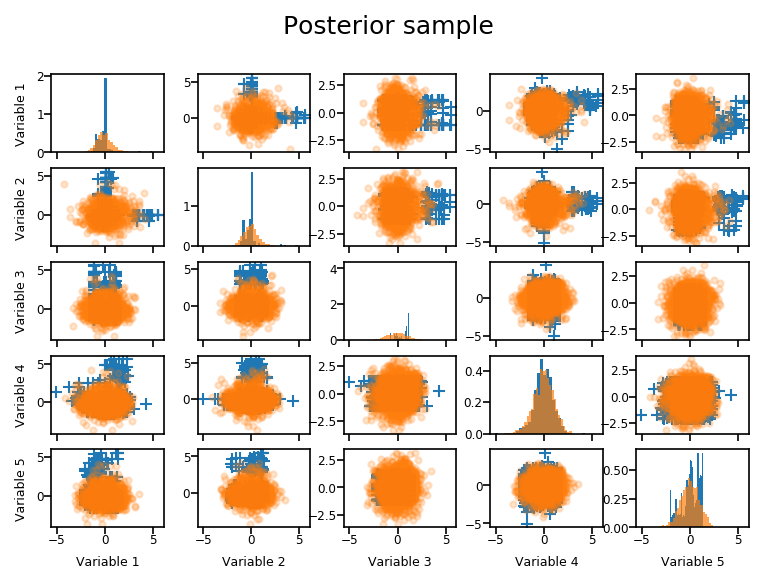

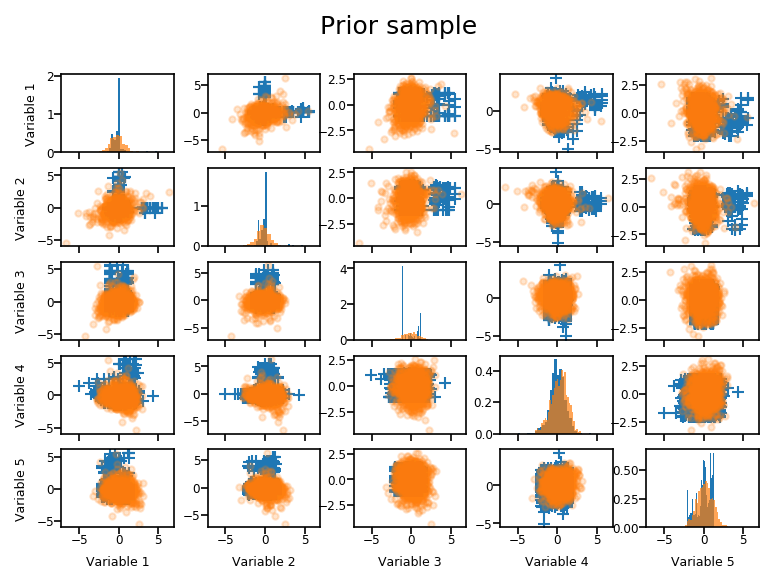

In [22]:
# GENERATE VALUES AND PLOT HISTOGRAMS
np_x = next_batch(Xdata_Missing, 2000)
# reconstruct data by sampling from distribution of reconstructed variables:
x_hat = vae.reconstruct(np_x, sample = 'sample')

x_hat_prior = vae.generate(n_samples = 1000)
x_hat_prior = x_hat_prior.eval()

subplotmax = min(n_x,5)
f, axarr = plt.subplots(subplotmax, subplotmax, sharex='col', dpi = 150)
f.suptitle('Posterior sample')
f.subplots_adjust(wspace = 0.3)
for k in range(subplotmax):
    for j in range(subplotmax):
        if k == j:
            axarr[k, j].hist(np_x[:,k],bins = 30, density=True)
            axarr[k, j].hist(x_hat[:,k],bins = 30, alpha = 0.7, density=True)
            axarr[k, j].tick_params(labelsize='xx-small', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable 1', fontsize=6)
            elif j == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(subplotmax), fontsize=6)
        else:
            axarr[k, j].plot(np_x[:,k], np_x[:,j], '+',label = 'Data')
            axarr[k, j].plot(x_hat[:,k], x_hat[:,j], '.', alpha = 0.2, label='Posterior')
            axarr[k, j].tick_params(labelsize='xx-small', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable ' + str(k+1), fontsize=6)
            if k == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(j+1), fontsize=6)

f, axarr = plt.subplots(subplotmax, subplotmax, sharex='col', dpi = 150)
f.suptitle('Prior sample')
f.subplots_adjust(wspace = 0.3)
for k in range(subplotmax):
    for j in range(subplotmax):
        if k == j:
            axarr[k, j].hist(np_x[:,k],bins = 30, density=True)
            axarr[k, j].hist(x_hat_prior[:,k],bins = 30, alpha = 0.7, density=True)
            axarr[k, j].tick_params(labelsize='xx-small', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable 1', fontsize=6)
            elif j == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(subplotmax), fontsize=6)
        else:
            axarr[k, j].plot(np_x[:,k], np_x[:,j], '+',label = 'Data')
            axarr[k, j].plot(x_hat_prior[:,k], x_hat_prior[:,j], '.', alpha = 0.2, label='Prior')
            axarr[k, j].tick_params(labelsize='xx-small', pad = 0)
            if j == 0:
                axarr[k, j].set_ylabel('Variable ' + str(k+1), fontsize=6)
            if k == subplotmax-1:
                axarr[k, j].set_xlabel('Variable ' + str(j+1), fontsize=6)

vae.sess.close()